In [1]:
import sys
sys.path.insert(0, "../../../pymc")

import numpy as np
import pymc as pm
import pandas as pd

import matplotlib.pyplot as plt

import arviz as az

%config InlineBackend.figure_format = "retina"
%matplotlib inline

In [2]:
M0 = 5; K = 19
N = 30 # = infinity according to frequentists
rng = np.random.RandomState(seed=34)

In [3]:
def generate_weights(M, rng, size):
    
    N, K = size
    betas = rng.beta(1., M, size=[N, K])
    
    sticks = np.hstack(
        [
            np.ones(shape=[N, 1]),
            np.cumprod(1 - betas[:, :-1], axis=1),
        ]
    )

    product = betas * sticks
    
    last_column = 1 - product.sum(axis=1)[..., np.newaxis]
    
    return np.hstack((product, last_column))

### 1 - Just inferring on `M`

In [4]:
weights = generate_weights(M0, rng, size=(N, 19))

In [5]:
with pm.Model() as model:
    M = pm.Uniform("M", 0, 10)
    sbw = pm.StickBreakingWeights("sbw", M, K, observed=weights)
    trace = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [M]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 6 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


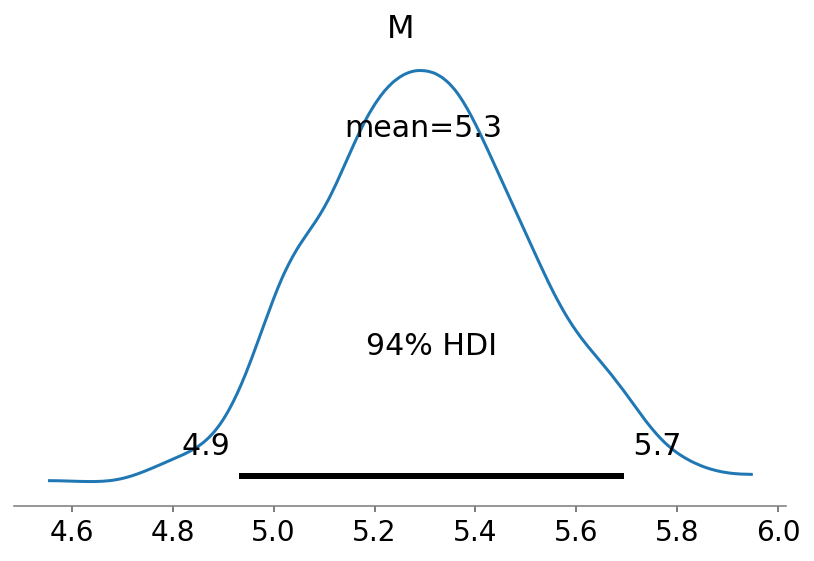

In [6]:
_ = az.plot_posterior(trace)
plt.tight_layout()

## 2 - Combining inference with drawn atoms

In [7]:
def simulate_atoms_weights(dist: str, para, size, M=M0, rng=rng):
    atoms = getattr(rng, dist)(**para, size=size)
    weights = generate_weights(M, rng, size)
    
    return atoms, weights

### 2.1 - Normal distribution

In [8]:
atoms, weights = simulate_atoms_weights(dist="normal", para={"loc": 3, "scale": 2}, size=[N, K])

with pm.Model() as model:
    M = pm.Uniform("M", 0, 10)
    μ = pm.Normal("μ", 0, 5)
    σ = pm.Gamma("σ", 2, 4)
    
    sbw = pm.StickBreakingWeights("sbw", M, K, observed=weights)
    G0 = pm.Normal("G0", μ, σ, observed=atoms)
    
    trace = pm.sample(draws=3000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [M, μ, σ]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


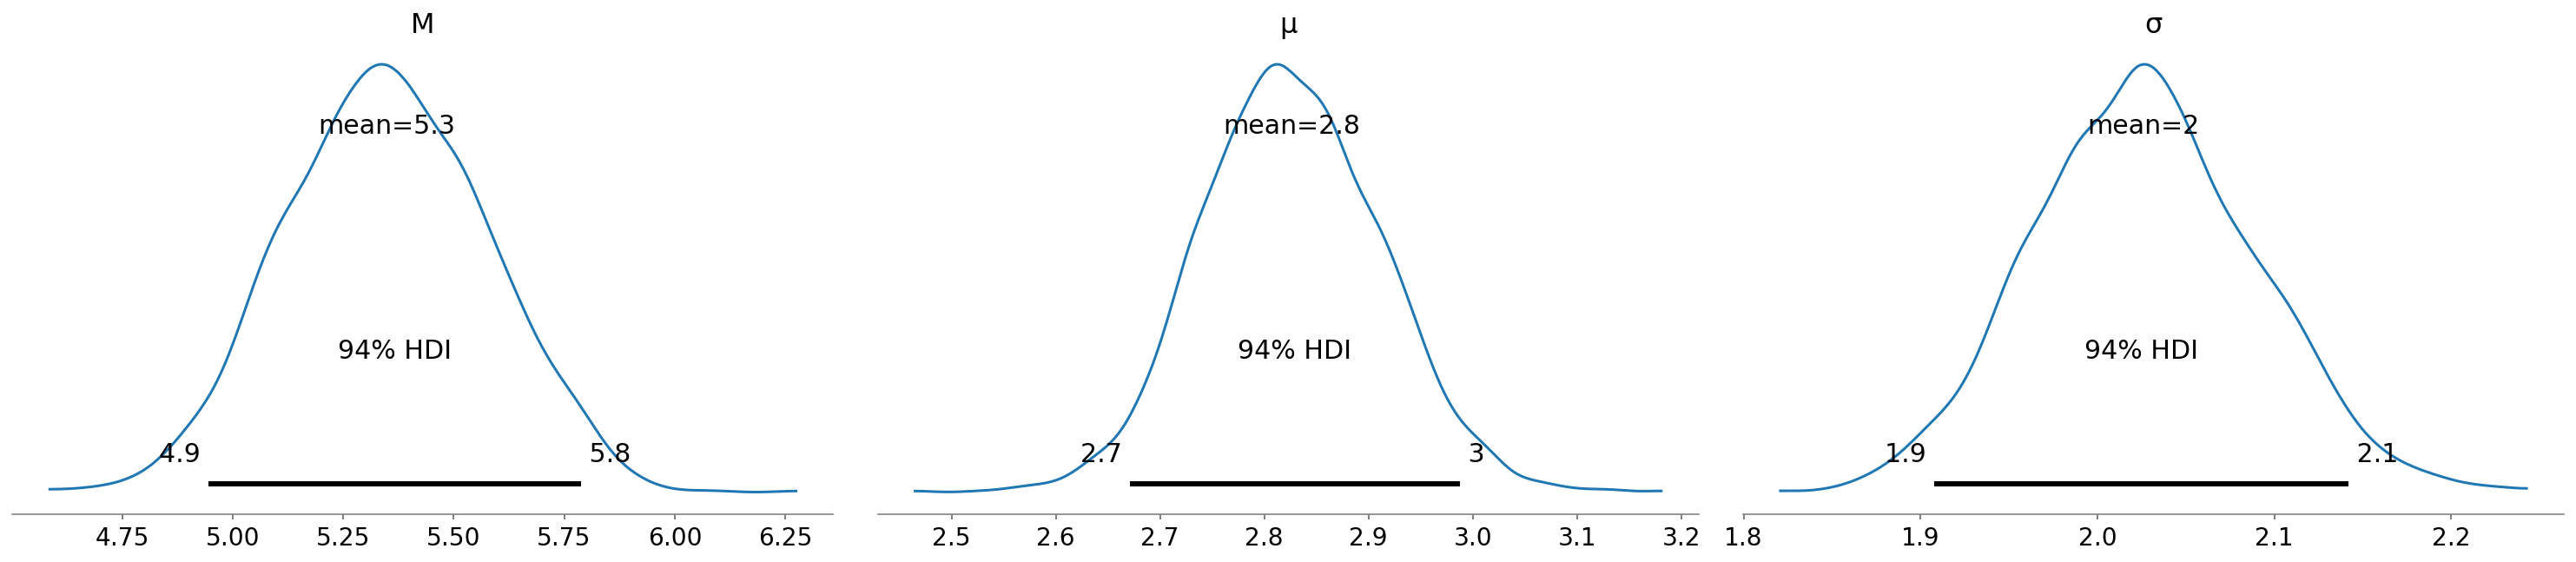

In [9]:
_ = az.plot_posterior(trace)
plt.tight_layout()

### 2.2 - Gamma distribution

In [10]:
atoms, weights = simulate_atoms_weights(dist="gamma", para={"shape": 2.5, "scale": 1/3}, size=[N, K])

with pm.Model() as model:
    M = pm.Uniform("M", 0, 10)
    α = pm.Gamma("α", 0.1, 0.1)
    β = pm.Gamma("β", 0.1, 0.1)
    
    sbw = pm.StickBreakingWeights("sbw", M, K, observed=weights)
    G0 = getattr(pm, "gamma".capitalize())("G0", α, β, observed=atoms)
    
    trace = pm.sample(draws=3000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [M, α, β]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 12 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


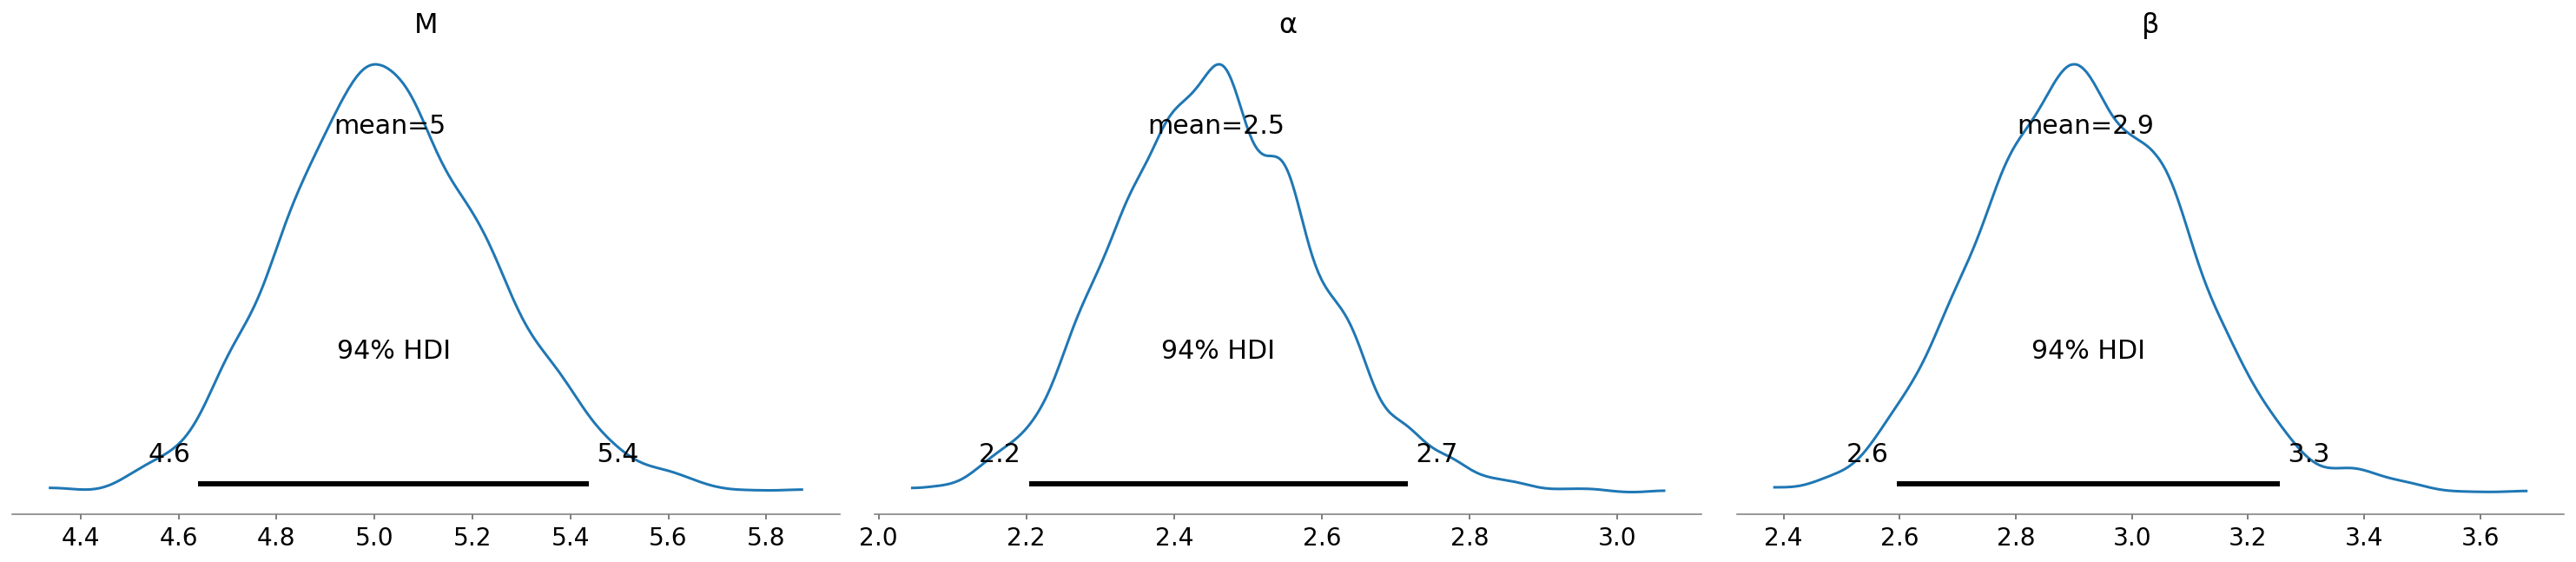

In [11]:
_ = az.plot_posterior(trace)
plt.tight_layout()

## 3 - Two level inference

In [12]:
K = 7 # can't have a too small truncation
M0 = 10

def simulate_dp_data(dist: str, para, size, M=M0, rng=rng):
    size = tuple(size)
    
    atoms, weights = simulate_atoms_weights(dist, para, size)
    
    res = np.empty(size[:-1] + (size[-1] + 1,))
    
    for idx in range(size[0]):
        res[idx] = rng.multinomial(n=K*1000, pvals=weights[idx])
        
    return res

In [13]:
dp_data = simulate_dp_data(dist="normal", para={"loc": 3, "scale": 2}, size=[N, K])

## 4 - Fitting a DP Posterior

In [14]:
x_obs = rng.normal(loc=2., scale=2., size=[50,])

with pm.Model() as model:
    alpha = pm.Uniform("alpha", 1., 10.)
    sbw = pm.StickBreakingWeights("sbw", alpha=alpha, K=10)
    G = pm.Multinomial("G", n=50, p=sbw)
    
    trace = pm.sample(draws=3000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [alpha, sbw]
>Metropolis: [G]


Sampling 1 chain for 1_000 tune and 3_000 draw iterations (1_000 + 3_000 draws total) took 33 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [15]:
prior.to_dict()["prior"]["sbw"][0, np.array([1314, 2266, 2304, 2473, 2521, 2997]), :]

NameError: name 'prior' is not defined

In [ ]:
prior.to_dict()["prior"]["alpha"][0][np.array([1314, 2266, 2304, 2473, 2521, 2997])]